In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
%matplotlib inline

In [2]:
!dir DATA\BANK

 Volume in drive N is RRVARRA_DATA
 Volume Serial Number is C6A7-C0FD

 Directory of N:\DOWNLOADS\Python\MLTutorial\DATA\BANK

01/27/2018  09:25 PM    <DIR>          .
01/27/2018  09:25 PM    <DIR>          ..
01/27/2018  09:23 PM           444,572 bank-additional.zip
01/27/2018  09:24 PM           579,043 bank.zip
               2 File(s)      1,023,615 bytes
               2 Dir(s)  535,510,925,312 bytes free


In [3]:
data_zip_file = r'DATA\BANK\bank-additional.zip'

with zipfile.ZipFile(data_zip_file) as zo:
    with zo.open('bank-additional/bank-additional-full.csv', 'r') as fd:
        df = pd.read_csv(fd, sep=';')
        


In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### There are many unknowns - some are in categorical ('nonexistent', 'unknown') some are numeric (999)
We need to find how much data can be removed by eliminating the rows with certain number of unknowns and make a decision.
Need to calculate # of unknowns for each sample

In [5]:
# performance comparisons of series comaparisions
x = df.iloc[1]

print('Using series bool logic')
%time np.sum((x == 'unknown') | (x == 'nonexistent') | (x == 999))

print ('Using value iteration in series')
%time np.sum(v == 'unknown' or v == 'nonexistent' or v == 999 for v in x)

Using series bool logic
Wall time: 2 ms
Using value iteration in series
Wall time: 0 ns


3

In [37]:
%%time
def unknows_by_row(x):
    '''
    generate bool series for each, and logical_or the series and sum
    '''
    return np.sum((x == 'unknown') | (x == 'nonexistent') | (x == 999))

# calcualate how many unknows we have in each row
nuk = df.apply(unknows_by_row, axis=1)


Wall time: 58.9 s


In [39]:
%%time
def unknows_by_row(x):
    '''
    iterate over each value of series and sum the Trues
    '''
    return np.sum(v == 'unknown' or v == 'nonexistent' or v == 999 for v in x)

# calcualate how many unknows we have in each row
nuk = df.apply(unknows_by_row, axis=1)

Wall time: 856 ms


In [6]:
%%time
def unknows_by_col(col, col_type):
    '''
    produce a series for each col with unknowns
    '''
    return df[col].isin(['unknown', 'nonexistent']) if col_type == np.object else df[col] == 999  

a = [unknows_by_col(col, col_type) for col, col_type in df.dtypes.items()]
df_a = pd.concat(a, axis=1)
nuk = df_a.sum(axis=1)

Wall time: 31 ms


In [63]:
%%time
nuk = df.apply(lambda x: x.isin(['unknown', 'nonexistent']) if x.dtype == np.object else x == 999).sum(axis=1)


Wall time: 36 ms


In [57]:
%%time
nuk = df.apply(lambda x: x.isin(['unknown', 'nonexistent', 999])).sum(axis=1)

Wall time: 65.1 ms


Shows the amount (%) of data lost if decide throw away samples with a certain # of unknowns. We are going to keep data upto 3 unknowns/sample which requires 3.6% of data loss.

In [13]:
nuk.value_counts().sort_index(ascending=False).cumsum()*100/len(df)

7      0.004856
6      0.053414
5      0.742935
4      3.644265
3     23.963290
2     88.319413
1     96.819462
0    100.000000
dtype: float64

In [12]:
# remove rows with more than 4 or more
df1 = df[nuk < 4]

In [75]:
len(df1)*100/len(df)

96.35573468000389

In [21]:
nuk.head()

0    2
1    3
2    2
3    2
4    2
dtype: int64

In [17]:
df.age.describe()

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64

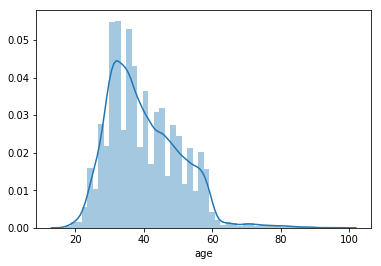

In [19]:
sns.distplot(df.age)

In [22]:
np.sum(df.age.isnull())

0

In [24]:
df.job.value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [10]:
# partition df1 into X, y
# Read: http://contrib.scikit-learn.org/categorical-encoding/
# Read about LabelEncoder and OneHotEncoder

In [50]:
df1_X = df1.drop(['duration', 'y'], axis=1)
df1_y = df1['y']

In [19]:
tdf = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})

In [20]:
tdf

,A,B
0,1,4
1,2,5
2,3,6


0    no
1    no
2    no
3    no
4    no
Name: y, dtype: object